In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split

from mapie.regression import MapieQuantileRegressor
from mapie.metrics import regression_coverage_score

import statistics

import sys
sys.path.insert(0,'./') # neccesary to load constants module
import constants as const

#SEED = 42
SEED = 81

2025-01-27 12:51:41.794201: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-27 12:51:41.827733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-27 12:51:42.437636: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# **Load pre-trained power model**

In [2]:
# import sys
# sys.path.insert(0,'./')  # add current to path to load constants module
# import constants as const

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import load_model
from keras import backend as K

Cp_max = 0.5926
V_mean = 6.314169410268349
V_std = 1.9826865496833004
Pres_mean = 548.729493
Pres_std = 30275.282659

#model_tf = load_model('../Models/Ptotal_Cp3D.h5')
#model_tf.save('../Models/modelP.keras')

In [3]:
model_tf = load_model(filepath='../Models/modelP.keras')
model_tf.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 lambda_5 (Lambda)              (None, 3)            0           ['input_6[0][0]']                
                                                                                                  
 lambda_6 (Lambda)              (None, 8)            0           ['input_6[0][0]']                
                                                                                                  
 model (Functional)             (None, 1)            17153       ['lambda_5[0][0]']               
                                                                                            

2025-01-27 12:52:49.651657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


#### Test to visualize the model

Index(['P'], dtype='object')
Index(['V', 'theta', 'W', 'theta.1', 'nacelle_temperature', 'V.1',
       'Vane_angle', 'Out_temperature', 'W.1', 'Rotor_temperature',
       'Wind_angle_c'],
      dtype='object')
(120530, 1)
(120530, 11)
3767/3767 [==============================] - 2s 420us/step


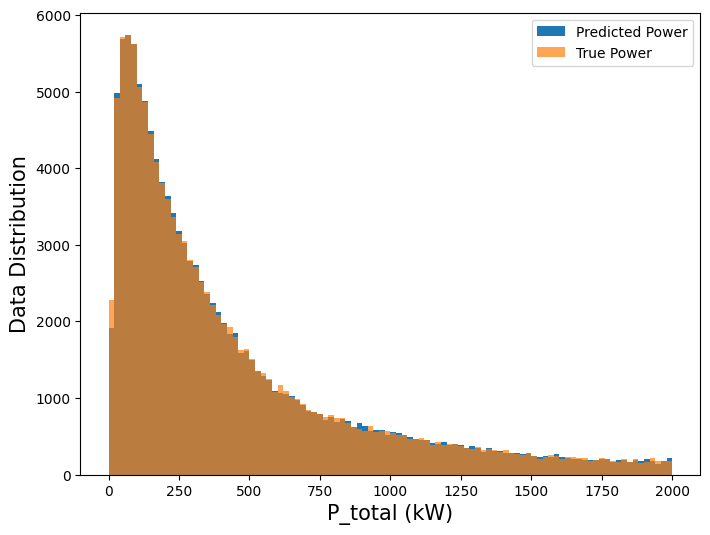

In [4]:
features_dataset = pd.read_csv('../Datasets/Dataset_test_features_UQ.csv')
P_dataset = pd.read_csv('../Datasets/Dataset_test_P_UQ.csv')

# Remove the first column (unnamed) if it exists
features_dataset = features_dataset.drop(columns=['Unnamed: 0'], errors='ignore')
P_dataset = P_dataset.drop(columns=['Unnamed: 0'], errors='ignore')
print(P_dataset.columns)
print(features_dataset.columns)
print(P_dataset.shape)
print(features_dataset.shape)

# Plot distributions of P_res in kW
Ptotal_data = model_tf.predict(features_dataset)
plt.figure(figsize=(8,6))
plt.hist(Ptotal_data/1000, range=[0, 2000], bins=100,label='Predicted Power')
plt.xlabel('P_total (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
#plt.title('Predicted Power',fontsize=20)
#plt.show()

Ptotal_data = P_dataset
#plt.figure(figsize=(4,4))
plt.hist(Ptotal_data/1000, range=[0, 2000], bins=100,label='True Power',alpha=0.7)
#plt.xlabel('P_total (kW)',fontsize=15)
#plt.ylabel('Data Distribution',fontsize=15)
#plt.title('True Power',fontsize=20)
plt.legend()
plt.show()

# **Prepare data**

Load, preprocess and split dat into test and calibration sets

In [5]:
def standarize(X, X_mean, X_std):
    return (X - X_mean) / X_std
def standarize_inv(X, X_mean, X_std):
    return X * X_std + X_mean

In [6]:
features_dataset = pd.read_csv('../Datasets/Dataset_test_features_UQ.csv')
P_dataset = pd.read_csv('../Datasets/Dataset_test_P_UQ.csv')

# Remove the first column (unnamed) if it exists
features_dataset = features_dataset.drop(columns=['Unnamed: 0'], errors='ignore')
P_dataset = P_dataset.drop(columns=['Unnamed: 0'], errors='ignore')

# Standarize Y data. X data is already standarized
P_mean = 444860.879260
P_std = 446349.165241
#P_dataset = (P_dataset - P_mean) / P_std
P_dataset = standarize(P_dataset,P_mean,P_std)

# Take a random sample
#sample_size = 10000
#features_sample = features_dataset.sample(n=sample_size, random_state=SEED)
#P_sample = P_dataset.loc[features_sample.index]  # Use the same indices for P_dataset
features_sample = features_dataset
P_sample = P_dataset

print(P_dataset.columns)
print(features_dataset.columns)
print(P_dataset.shape)
print(features_dataset.shape)

print(P_sample.shape)
print(features_sample.shape)

Index(['P'], dtype='object')
Index(['V', 'theta', 'W', 'theta.1', 'nacelle_temperature', 'V.1',
       'Vane_angle', 'Out_temperature', 'W.1', 'Rotor_temperature',
       'Wind_angle_c'],
      dtype='object')
(120530, 1)
(120530, 11)
(120530, 1)
(120530, 11)


In [7]:
# Convert pd dataframe to numpy 
features_sample = features_sample.to_numpy()
P_sample = P_sample.to_numpy()

# Split data
X_cal, X_test, y_cal, y_test = train_test_split(features_sample, P_sample, test_size=0.5, random_state=SEED)
""" features_dataset = features_dataset.to_numpy()
P_dataset = P_dataset.to_numpy()
X_cal, X_test, y_cal, y_test = train_test_split(features_dataset, P_dataset, test_size=0.5, random_state=SEEd) """
print(X_cal.shape)
print(y_cal.shape)
print(X_test.shape)
print(y_test.shape)

# Flatten y to run Mapie Quantile Regressor later
y_cal = y_cal.flatten()
y_test = y_test.flatten()

(60265, 11)
(60265, 1)
(60265, 11)
(60265, 1)


# **Train and save quantile models**

Create, train and save Keras models:

* `model_up` with tau = (1-alpha/2)
* `model_low` with tau = alpha/2
* `model` with tau = 0.5

In [8]:
# Define alpha for quantiles

alpha = 0.1

def pinball_loss(y_true, y_pred, tau=0.5):
    error = y_true - y_pred
    return tf.reduce_mean(tf.maximum(tau * error, (tau - 1) * error))

def plot_loss(history):
    
    # Plot the loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss [P_res]')
    plt.legend()
    plt.grid(True)

    val_loss_per_epoch = history.history['val_loss']
    train_loss_per_epoch = history.history['loss']
    best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))


In [9]:
# Define the model architecture
def create_model(input_shape, tau):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Single output for quantile regression
    ])
    loss_fn = lambda y_true, y_pred: pinball_loss(y_true, y_pred, tau=tau)
    model.compile(optimizer=Adam(), loss=loss_fn)
    return model

Epoch 1/150
377/377 [==============================] - 1s 1ms/step - loss: 0.0165 - val_loss: 0.0070 - lr: 0.0010
Epoch 2/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0070 - lr: 0.0010
Epoch 3/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0063 - lr: 0.0010
Epoch 4/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0056 - lr: 0.0010
Epoch 5/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0061 - lr: 0.0010
Epoch 6/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0056 - lr: 0.0010
Epoch 7/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0068 - lr: 0.0010
Epoch 8/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0054 - lr: 0.0010
Epoch 9/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0060 - val_

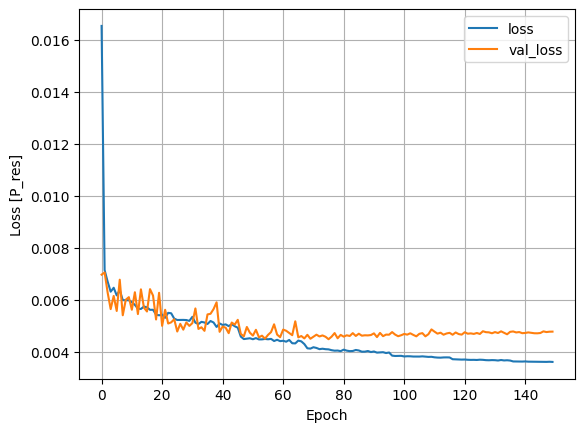

In [192]:
# Train upper quantile estimation with a neural network

# Parameters
input_shape = X_cal.shape[1]
tau = (1 - alpha / 2) 

# Create the model
model_up = create_model(input_shape, tau)

# Train the model
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=20, min_lr=1e-6)
history_up = model_up.fit(X_cal, y_cal, epochs=150, batch_size=128, validation_split=0.2,callbacks=[reduce_lr])

# Save the model
model_up.save('../Models/modelP_up.keras')

plot_loss(history_up)

Epoch 1/150
377/377 [==============================] - 1s 1ms/step - loss: 0.0136 - val_loss: 0.0068 - lr: 0.0010
Epoch 2/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0052 - lr: 0.0010
Epoch 3/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0052 - lr: 0.0010
Epoch 4/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0057 - lr: 0.0010
Epoch 5/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0058 - lr: 0.0010
Epoch 6/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0053 - lr: 0.0010
Epoch 7/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0047 - lr: 0.0010
Epoch 8/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0048 - lr: 0.0010
Epoch 9/150
377/377 [==============================] - 0s 1ms/step - loss: 0.0048 - val_

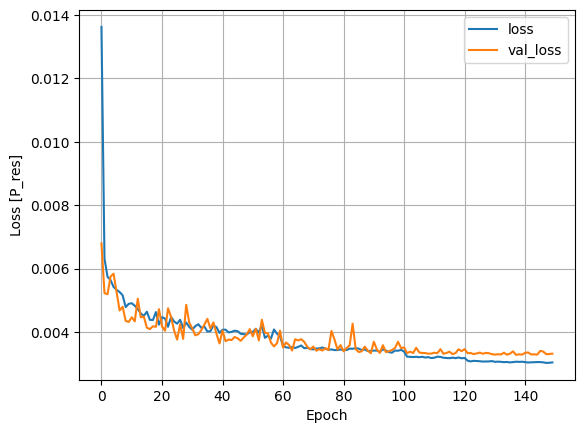

In [ ]:
# Train lower quantile estimation with a neural network

# Parameters
input_shape = X_cal.shape[1]
tau = alpha / 2

# Create the model
model_low = create_model(input_shape, tau)

# Train the model
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=20, min_lr=1e-6)
history_low = model_low.fit(X_cal, y_cal, epochs=100, batch_size=150, validation_split=0.2,callbacks=[reduce_lr])

# Save the model
model_low.save('../Models/modelP_low.keras')

plot_loss(history_low)

In [156]:
# Function to define a model predicting power in original non-normalized units
def original_units_model(P_model, P_std, P_mean):
    """
    Creates a new model that applies scaling to the output of a given pre-trained model.

    Args:
        P_model (tf.keras.Model): The pre-trained model.
        P_std (float): The scaling standard deviation.
        P_mean (float): The scaling mean.

    Returns:
        tf.keras.Model: A new model with scaled output.
    """
    inputs = P_model.input
    P = P_model.output

    # Apply the scaling transformation: P' = P * P_std + P_mean
    P_prime = P * P_std + P_mean

    # Create and return the new model
    scaled_model = tf.keras.Model(inputs=inputs, outputs=P_prime)
    return scaled_model

In [ ]:
# save models
model_up_units = original_units_model(model_up,P_std,P_mean)
model_up_units.save('../Models/modelP_up_units.keras')
model_low_units = original_units_model(model_low,P_std,P_mean)
model_low_units.save('../Models/modelP_low_units.keras')


In [10]:
model_up_units = load_model('../Models/modelP_up_units.keras')
model_low_units = load_model('../Models/modelP_low_units.keras')

In [11]:
# Check quantile estimations

P_pred = model_tf.predict(X_test).flatten()
P_low = model_low_units.predict(X_test).flatten()
P_up = model_up_units.predict(X_test).flatten()

for i in range(10):
    print(P_pred[i]/1000,P_low[i]/1000,P_up[i]/1000,abs(P_up[i]-P_low[i])/1000)

1884/1884 [==============================] - 1s 361us/step
507.03375 501.89996875 510.00265625 8.1026875
305.60315625 300.76546875 308.63125 7.86578125
30.7580078125 9.43221875 41.796125 32.36390625
465.561375 463.15703125 500.1431875 36.98615625
110.300578125 109.5206875 114.30509375 4.78440625
1399.70375 1303.31 1475.359 172.049
344.1675625 339.02940625 359.332375 20.30296875
1084.60925 1028.920125 1164.722 135.801875
2007.87375 1956.01975 2063.94525 107.9255
662.8695 622.7370625 716.21275 93.4756875


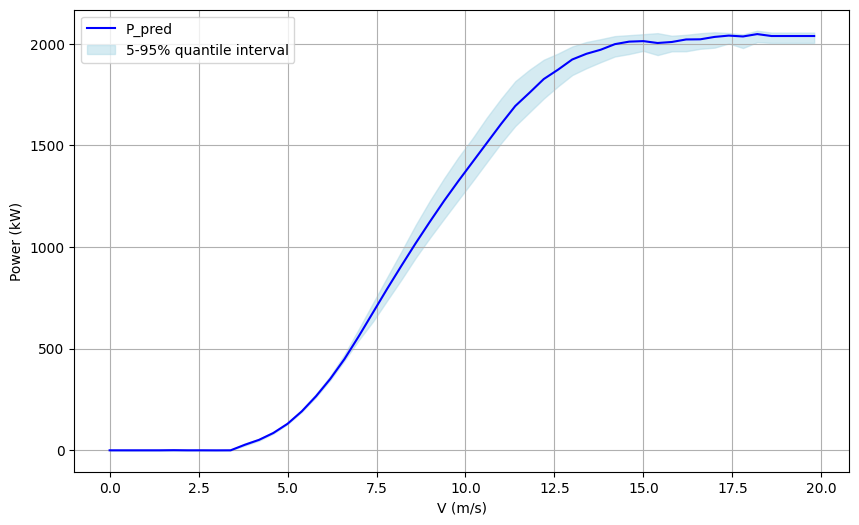

In [12]:
# Smooth plot

V_data = X_test[:, 0].copy()
V_data = standarize_inv(V_data,V_mean,V_std)
P_data_pred = P_pred.copy()/1000
P_data_low = P_low.copy()/1000
P_data_up = P_up.copy()/1000

# v binning
vmin = 0
vmax = 20
nbins = 50
dv = (vmax-vmin)/nbins
V_estimated = np.zeros(nbins)
P_estimated_pred = np.zeros(nbins)
P_estimated_low = np.zeros(nbins)
P_estimated_up = np.zeros(nbins)

for i in range(1,nbins):
    vl = vmin + i*dv
    vr = vl + dv

    # Mean of P in the bin i
    V_estimated[i] = (vl+vr)/2.0
    v_subset = (vl<V_data) & (V_data<vr)  # subset of V points of the bin
    Pi_pred = P_data_pred[v_subset]     # P distribution of bin i
    Pi_low = P_data_low[v_subset]
    Pi_up = P_data_up[v_subset]
    if (len(Pi_pred)>0):
        P_estimated_pred[i]=statistics.mean(Pi_pred)
        P_estimated_low[i]=statistics.mean(Pi_low)
        P_estimated_up[i]=statistics.mean(Pi_up)
    elif(i>0):
        P_estimated_pred[i] = P_estimated_pred[i-1]
        P_estimated_low[i] = P_estimated_low[i-1]
        P_estimated_up[i] = P_estimated_up[i-1]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(V_estimated, P_estimated_pred, label='P_pred', color='blue', linewidth=1.5)
plt.fill_between(V_estimated, P_estimated_low, P_estimated_up, color='lightblue', alpha=0.5, label='5-95% quantile interval')
plt.xlabel('V (m/s)')
plt.ylabel('Power (kW)')
#plt.title('y_pred with Uncertainty Intervals')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Compute coverage and average lenght of uncertainty intervals

# Mean Coverage
P_true = standarize_inv(y_test,P_mean,P_std)/1000
coverage = 100*regression_coverage_score(P_true,P_data_low,P_data_up)

# Mean Interval Length
interval_length = np.mean(P_data_up - P_data_low)

print("Mean Coverage:", coverage)
print("Mean Interval Length:", interval_length)

Mean Coverage: 86.6589230896872
Mean Interval Length: 49.41454


/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


# **MAPIE**

Load and wrap for `sklearn` compatibility (the wrapper assumes that the model is already trained):

In [14]:
class TrainedKerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

    def __sklearn_is_fitted__(self):
        return True

#model_files = ['modelP.keras', 'modelP.keras', 'modelP.keras']
#model_files = ['modelP_low.keras', 'modelP_up.keras', 'modelP.keras']
model_files = ['../Models/modelP_low_units.keras', '../Models/modelP_up_units.keras', '../Models/modelP.keras']
wrapped_models = []

for file in model_files:
    loaded_model = load_model(file, compile=False)
    wrapped_model = TrainedKerasRegressorWrapper(loaded_model)
    wrapped_models.append(wrapped_model)

MAPIE quantile regression.

The list of estimators consist of:

* [0]: Estimator with quantile value of alpha/2
* [1]: Estimator with quantile value of 1 - alpha/2
* [2]: Estimator with quantile value of 0.5
```

In [16]:
mapie_regressor = MapieQuantileRegressor(
    estimator=wrapped_models, cv='prefit')

mapie_regressor.fit(X_cal, standarize_inv(y_cal,P_mean,P_std))

predictions, intervals = mapie_regressor.predict(X_test)

lower_intervals = intervals[:, 0]
upper_intervals = intervals[:, 1]

results = pd.DataFrame({
    'Prediction': predictions.flatten(),
    'Lower Interval': lower_intervals.flatten(),
    'Upper Interval': upper_intervals.flatten(),
    'Amplitude': upper_intervals.flatten() - lower_intervals.flatten(),
    'Actual Value': standarize_inv(y_test,P_mean,P_std)
})

results.head()

 223/1884 [==>...........................] - ETA: 0s

/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/mapie/regression/quantile_regression.py:201: UserWarning: WARNING: The alpha that is set needs to be the same as the alpha of your prefitted model in the following order [alpha/2, 1 - alpha/2, 0.5]
  warnings.warn(


1884/1884 [==============================] - 1s 471us/step


/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


,Prediction,Lower Interval,Upper Interval,Amplitude,Actual Value
0,507033.750000,501977.12500,509925.50000,7948.37500,504760.01
1,305603.156250,300842.62500,308554.09375,7711.46875,304570.01
2,30758.007812,9509.37500,41718.96875,32209.59375,16670.00
3,465561.375000,463234.18750,500066.03125,36831.84375,476829.99
4,110300.578125,109597.84375,114227.93750,4630.09375,112410.00


In [17]:
# Coverage and mean interval length

# Coverage
coverage_cqr = 100*regression_coverage_score(
    standarize_inv(y_test,P_mean,P_std),
    lower_intervals,
    upper_intervals
)

# Mean Interval Length
interval_length = np.mean(upper_intervals - lower_intervals)/1000

print("Mean Coverage:", coverage_cqr)
print("Mean Interval Length:", interval_length)

Mean Coverage: 86.04330871982079
Mean Interval Length: 49.26023019528333


/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


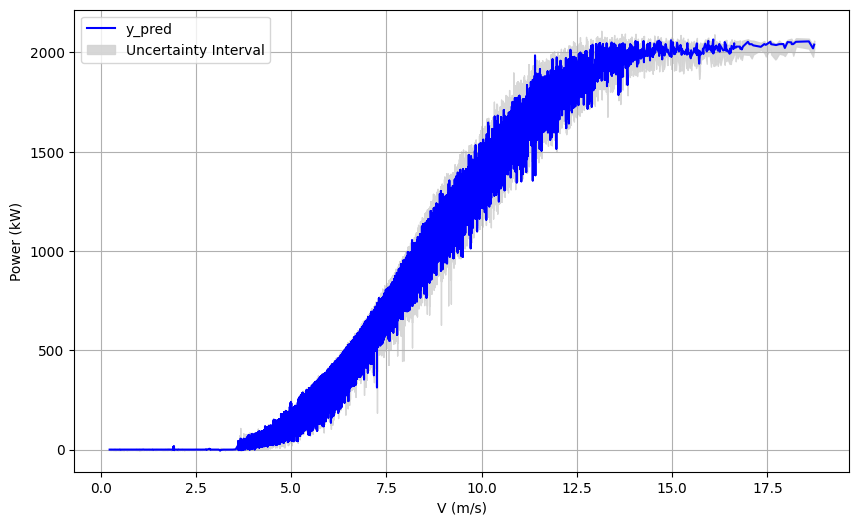

In [18]:
V_true = X_test[:, 0]  # Extract the first feature
y_true = np.array(y_test)    # Ensure y_test is a NumPy array
y_pred = predictions.flatten()
#lower_limit = intervals[:, 0, 0]  # Extract lower limit from intervals
#upper_limit = intervals[:, 1, 0]  # Extract upper limit from intervals
lower_limit = lower_intervals.flatten()
upper_limit = upper_intervals.flatten()

# Sort by the first feature
sorted_indices = np.argsort(V_true)
V_true_sorted = V_true[sorted_indices]
y_true_sorted = y_true[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]
lower_limit_sorted = lower_limit[sorted_indices]
upper_limit_sorted = upper_limit[sorted_indices]

# Plot the data
plt.figure(figsize=(10, 6))
#plt.scatter(standarize_inv(V_true_sorted,V_mean,V_std), standarize_inv(y_true_sorted,P_mean,P_std)/1000, label='y_true', color='black')
#plt.plot(standarize_inv(V_true_sorted,V_mean,V_std), standarize_inv(y_true_sorted,P_mean,P_std)/1000, label='y_true', color='black',linewidth=1.5)
plt.plot(standarize_inv(V_true_sorted,V_mean,V_std), y_pred_sorted/1000, label='y_pred', color='blue', alpha=1.0,linewidth=1.5)
plt.fill_between(standarize_inv(V_true_sorted,V_mean,V_std), lower_limit_sorted/1000, upper_limit_sorted/1000, color='lightgray', alpha=0.9, label='Uncertainty Interval')
plt.xlabel('V (m/s)')
plt.ylabel('Power (kW)')
#plt.title('y_pred with Uncertainty Intervals')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Coverage and mean interval length

# Coverage
coverage_cqr = 100*regression_coverage_score(
    standarize_inv(y_test,P_mean,P_std),
    lower_limit,
    upper_limit
)

# Mean Interval Length
interval_length = np.mean(upper_limit - lower_limit)/1000

print("Mean Coverage:", coverage_cqr)
print("Mean Interval Length:", interval_length)

Mean Coverage: 86.04330871982079
Mean Interval Length: 49.26023019528333


/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


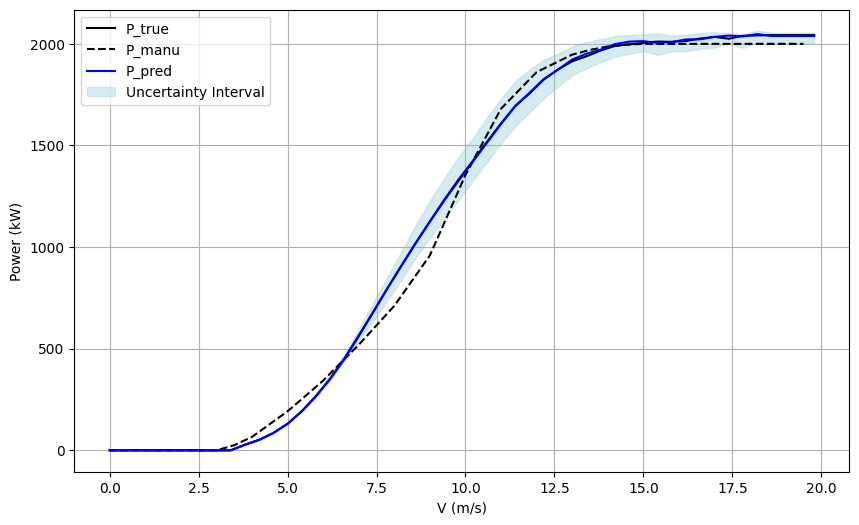

In [25]:
import statistics

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

V_data = V_true.copy()
V_data = standarize_inv(V_data,V_mean,V_std)
P_data = y_true.copy()
P_data = standarize_inv(P_data,P_mean,P_std)/1000
P_pred = y_pred.copy()/1000
P_data_low = lower_limit.copy()
P_data_low = P_data_low/1000
P_data_up = upper_limit.copy()
P_data_up = P_data_up/1000

# v binning
vmin = 0
vmax = 20
nbins = 50
dv = (vmax-vmin)/nbins
V_estimated = np.zeros(nbins)
P_estimated = np.zeros(nbins)
P_estimated_pred = np.zeros(nbins)
P_estimated_low = np.zeros(nbins)
P_estimated_up = np.zeros(nbins)

for i in range(1,nbins):
    vl = vmin + i*dv
    vr = vl + dv

    # Mean of P in the bin i
    V_estimated[i] = (vl+vr)/2.0
    v_subset = (vl<V_data) & (V_data<vr)  # subset of V points of the bin
    Pi = P_data[v_subset]     # P distribution of bin i
    Pi_pred = P_pred[v_subset]     # P distribution of bin i
    Pi_low = P_data_low[v_subset]
    Pi_up = P_data_up[v_subset]
    if (len(Pi)>0):
        P_estimated[i]=statistics.mean(Pi)
        P_estimated_pred[i]=statistics.mean(Pi_pred)
        P_estimated_low[i]=statistics.mean(Pi_low)
        P_estimated_up[i]=statistics.mean(Pi_up)
    elif(i>0):
        P_estimated[i] = P_estimated[i-1]
        P_estimated_pred[i] = P_estimated_pred[i-1]
        P_estimated_low[i] = P_estimated_low[i-1]
        P_estimated_up[i] = P_estimated_up[i-1]
        
# Power curve from manufacturer
V_manu = np.arange(0,22.5,0.5)
P_manu = [0,0,0,0,0,0,0,25,66,129,192,267,343,431,519,615,711,835,959,1157,1355,1518,1681,1771,1861,
1904,1947,1970,1987,1996,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,
2000, 2000, 2000]
P_manu = np.array(P_manu)
P_manu = P_manu[ V_manu<vmax ]
V_manu = V_manu[ V_manu<vmax ]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(V_estimated, P_estimated, label='P_true', color='black', linewidth=1.5)
plt.plot(V_manu, P_manu, 'k--',label='P_manu', linewidth=1.5)
plt.plot(V_estimated, P_estimated_pred, label='P_pred', color='blue', linewidth=1.5)
plt.fill_between(V_estimated, P_estimated_low, P_estimated_up, color='lightblue', alpha=0.5, label='Uncertainty Interval')
plt.xlabel('V (m/s)')
plt.ylabel('Power (kW)')
#plt.title('y_pred with Uncertainty Intervals')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Coverage and mean interval length

# Coverage
coverage_cqr = 100*regression_coverage_score(P_data,P_data_low,P_data_up)

# Mean Interval Length
interval_length = np.mean(upper_limit - lower_limit)/1000

print("Mean Coverage:", coverage_cqr)
print("Mean Interval Length:", interval_length)

Mean Coverage: 86.04330871982079
Mean Interval Length: 49.26023019528333


/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


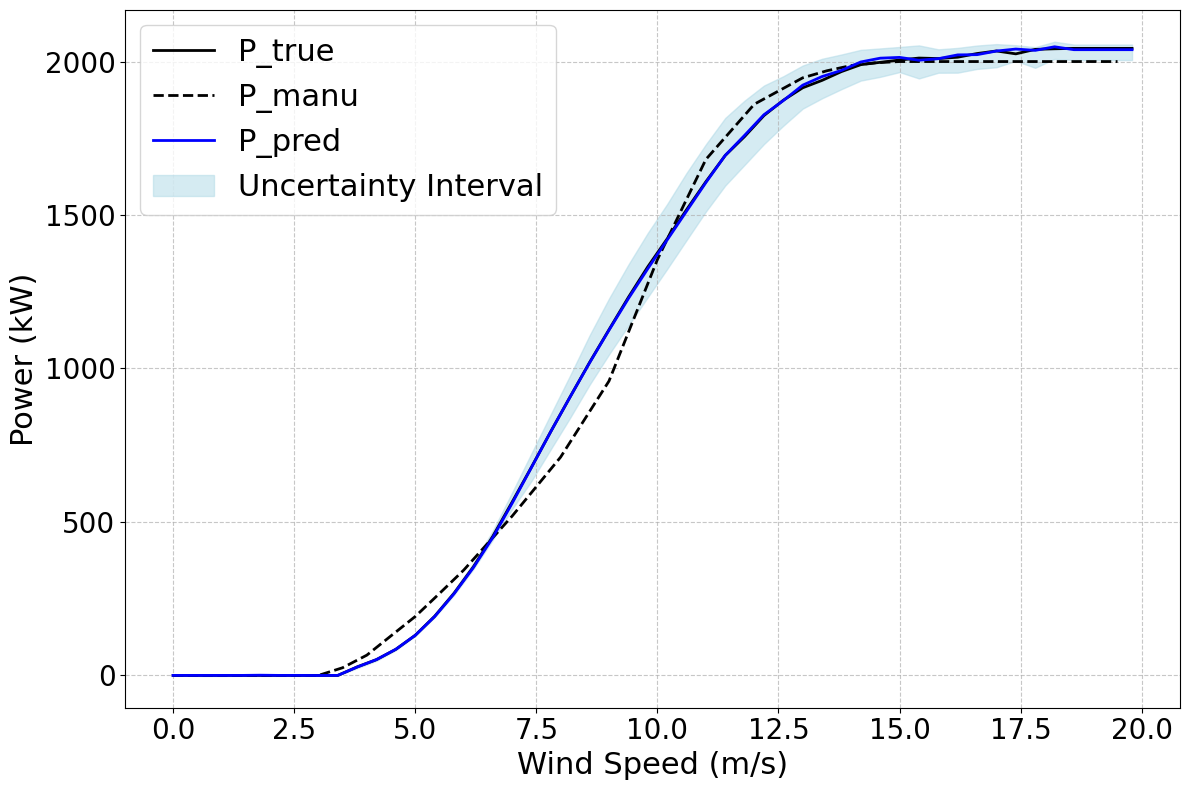

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import statistics

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Data preparation
V_data = V_true.copy()
V_data = standarize_inv(V_data, V_mean, V_std)
P_data = y_true.copy()
P_data = standarize_inv(P_data, P_mean, P_std) / 1000
P_pred = y_pred.copy() / 1000
P_data_low = lower_limit.copy() / 1000
P_data_up = upper_limit.copy() / 1000

# Binning
vmin = 0
vmax = 20
nbins = 50
dv = (vmax - vmin) / nbins
V_estimated = np.zeros(nbins)
P_estimated = np.zeros(nbins)
P_estimated_pred = np.zeros(nbins)
P_estimated_low = np.zeros(nbins)
P_estimated_up = np.zeros(nbins)

for i in range(1, nbins):
    vl = vmin + i * dv
    vr = vl + dv

    # Mean of P in the bin i
    V_estimated[i] = (vl + vr) / 2.0
    v_subset = (vl < V_data) & (V_data < vr)  # Subset of V points of the bin
    Pi = P_data[v_subset]  # P distribution of bin i
    Pi_pred = P_pred[v_subset]  # P_pred distribution of bin i
    Pi_low = P_data_low[v_subset]
    Pi_up = P_data_up[v_subset]
    if len(Pi) > 0:
        P_estimated[i] = statistics.mean(Pi)
        P_estimated_pred[i] = statistics.mean(Pi_pred)
        P_estimated_low[i] = statistics.mean(Pi_low)
        P_estimated_up[i] = statistics.mean(Pi_up)
    elif i > 0:
        P_estimated[i] = P_estimated[i-1]
        P_estimated_pred[i] = P_estimated_pred[i-1]
        P_estimated_low[i] = P_estimated_low[i-1]
        P_estimated_up[i] = P_estimated_up[i-1]

"""
# Power curve from manufacturer
V_manu = np.arange(0, 22.5, 0.5)
P_manu = [0, 0, 0, 0, 0, 0, 0, 25, 66, 129, 192, 267, 343, 431, 519, 615, 711, 835, 959, 1157, 1355, 1518,
          1681, 1771, 1861, 1904, 1947, 1970, 1987, 1996, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000,
          2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
P_manu = np.array(P_manu)
P_manu = P_manu[V_manu < vmax]
V_manu = V_manu[V_manu < vmax]
"""

# Ensure `P_manu` matches the length of `V_manu`
V_manu = np.arange(0, 22.5, 0.5)
P_manu = [0, 0, 0, 0, 0, 0, 0, 25, 66, 129, 192, 267, 343, 431, 519, 615, 711, 835, 959, 1157, 1355, 1518,
          1681, 1771, 1861, 1904, 1947, 1970, 1987, 1996, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000,
          2000, 2000, 2000, 2000, 2000, 2000, 2000]
P_manu = np.array(P_manu[:len(V_manu)])  # Trim P_manu to match V_manu

# Mask values below `vmax`
P_manu = P_manu[V_manu < vmax]
V_manu = V_manu[V_manu < vmax]

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(V_estimated, P_estimated, label='P_true', color='black', linewidth=2)
plt.plot(V_manu, P_manu, 'k--', label='P_manu', linewidth=2)
plt.plot(V_estimated, P_estimated_pred, label='P_pred', color='blue', linewidth=2)
plt.fill_between(V_estimated, P_estimated_low, P_estimated_up, color='lightblue', alpha=0.5, label='Uncertainty Interval')

# Improved labels, ticks, and legend
plt.xlabel('Wind Speed (m/s)', fontsize=22)
plt.ylabel('Power (kW)', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=22, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()